# TP Coding Convolutional Neural Networks in tensorflow and keras - part 2

Author : Alasdair Newson

alasdair.newson@telecom-paristech.fr

In this session, we shall be looking at two subjects :

- A way to visualise what networks are learning : the Deep Dream algorithm
- Adversarial examples

For this, we shall use a famous pretrained network : VGG16. At the heart of these applications is the calculation of the gradient of a loss function with respect to the image itself (instead of respect to the weights). The loss function will be defined depending on the application at hand.

We can easily access certain well-known networks with the Keras programming framework. There are useful predefined function which allow us to load the weights, view the architecture etc. of the networks. We will specify these functions as necessary through the lab work. Unfortunately, the documentation for these functions is not very plentiful, but if you want to look at exactly what they do, you can look at the source code for help :

https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py

https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

However, we will indicate how these functions work as the need arises.


First, let's load the necessary packages.

In [0]:
import numpy as np
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import vgg16
#from keras.applications import inception_v3
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

You'll notice that we have loaded the 'backend'. This allows us to access certain functions of the underlying backend layer without knowing the framework-specific syntax : Keras deals with everything. As we shall see, this will be useful later on.

Now, let's load one of the most famous networks, VGG16, and view it's architecture with the summary() function.

In [0]:
# This removes all operations linked to training the model
K.set_learning_phase(0)
#load model. include_top=False means that we do not load the last fully connected layer(s) necessary for classification
model=vgg16.VGG16(weights='imagenet',include_top=False)

The 'summary' function gives a summary of the architecture so that we can reference its different layers

In [54]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

You can extract one of the layers of the network with the following function

In [55]:
#put the layers in an easy-to-reference dictionary
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
#get the layer corresponding to the 5th block and second convolution
layer_out = layer_dict['block5_conv2'].output
layer_out.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(512)])

You can also extract the weights of the convolutional filters in VGG16. You can do this with the following function :

- weights = layer.get_weights()

where 'layer' iterates throughout the 'model.layers' list. Note that this function returns the following :
- [weights, biases] if the layer is convolutional. weights has size [m,n,filter_depth,n_filters]
- an empty list otherwise

Write a function which retrieves the weights of the network (you will have to test if the weights variable is empty at each iteration).
    

In [56]:
def retrieve_weights(model):
    weight_list = []
    # BEGIN CODE HERE
    for layer in model.layers:
      if layer.get_weights() != []:
        weight_list += [layer.get_weights()[0]]
    # END CODE HERE
    return weight_list
len(retrieve_weights(model))

(1728,)
(36864,)
(73728,)
(147456,)
(294912,)
(589824,)
(589824,)
(1179648,)
(2359296,)
(2359296,)
(2359296,)
(2359296,)
(2359296,)


13

Now, write a code that visualises a single channel of a filter of your choice. Reminder, to view a grey-level image, you can use :

- plt.imshow(img,cmap="gray")
- plt.show()

(1728,)
(36864,)
(73728,)
(147456,)
(294912,)
(589824,)
(589824,)
(1179648,)
(2359296,)
(2359296,)
(2359296,)
(2359296,)
(2359296,)


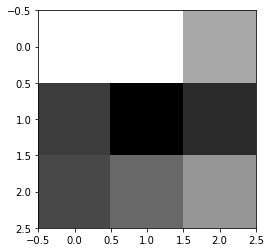

In [57]:
weight_list = retrieve_weights(model)
curr_weight = weight_list[2]
curr_weight.shape
plt.imshow(curr_weight[:,:,0,1],cmap="gray")

In [58]:
curr_weight[:,:,0,1]

array([[ 0.03781697,  0.03759558,  0.01217471],
       [-0.01912256, -0.03680309, -0.02436409],
       [-0.01577048, -0.00621745,  0.00700018]], dtype=float32)

As you can probably see, this visualisation is not of much use : we cannot really tell what is going on in the network. For this, let's turn to another approach : Deep Dream !

## 2. Deep Dream

We now proceed to carry out the Deep Dream algorithm. The idea of the Deep Dream algorithm is to find an image which maximises the response of a network at a certain layer : $\textbf{this should help us understand what the network is learning}$. This can be done with an iterative algorithm, by simply carrying out gradient $\textbf{ascension}$. We start with an input image and iteratively add the gradient of the average response of the features which interest us. A pseudo-code for this would be :

- img = img_in
- for i=1:n_iters
    - img = img + grad_step $\nabla_{img} \mathcal{L}$,
    
where $\mathcal{L}$ is the average response which interest us (you need to define this).

Let's first define a function to preprocess the image. This is needed to put the image in the correct format for the VGG16 network. We also create a function to invert this process.

In [0]:
def format_image(img_file=None):
    """
    This function reads and formats an image so that it can be fed to the VGG16 network
    
    Parameters
    ----------
    img_file : image file name
    
    Returns
    -------
    img_out_vgg : the correctly formatted image for VGG16
    img : the image as read by the load_img function of keras.preprocessing.image
    """
    # read image
    img = load_img(img_file)
    # convert image to an array
    img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16 network trained on imagenet
    img_out_vgg = vgg16.preprocess_input(img_out)
    # add a dimension at the beginning, coresponding to the batch dimension
    img_out_vgg = np.expand_dims(img_out_vgg, axis=0)
    return img_out_vgg, img

def unformat_image(img_in):
    """
    This function inverts the preprocessing applied to images for use in the VGG16 network
    
    Parameters
    ----------
    img_file : formatted image of shape (batch_size,m,n,3)
    
    Returns
    -------
    img_out : a m-by-n-by-3 array, representing an image that can be written to an image file
    """
    #get rid of batch dimension
    img_out=np.squeeze(img_in)
    #remove offsets added by the VGG16 preprocessing
    img_out[:, :, 0] += 103.939
    img_out[:, :, 1] += 116.779
    img_out[:, :, 2] += 123.68
    # invert the order of the colours : BGR -> RGB
    img_out = img_out[:, :, ::-1]
    #clamp image to the range [0,255] and cast to uint8
    img_out = np.clip(img_out, 0, 255).astype('uint8')
    return img_out

Now, we load the image. At the same time, we create a backend Tensor which has the correct format for the network.

**NOTE** : if you are using colab, then you might not be able to easily upload the images of the lab work. In this case you can use download the image directly from the url given (this is done for you). To modify the behaviour, change the ```using_colab``` variable.

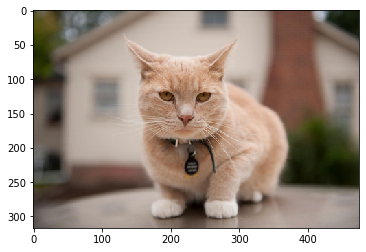

In [94]:
from google_drive_downloader import GoogleDriveDownloader as gdd
using_colab = True

#load image
if (using_colab == True):
    gdd.download_file_from_google_drive(file_id='1SHiTiIQTMZQivhsfQ_YcHvEN6LYaiwGk',
dest_path='./cat_small.png')
    img_in,img_visu = format_image('cat_small.png')
else:
    img_in,img_visu = format_image('images/got.jpg')

#create a Tensor in the correct format for the network using the backend framework (Keras in this case)
img_backend = model.input
#show the input image
plt.imshow(img_visu)
plt.show()

Now, we define the loss that we wish to maximise. This can be anything you wish, but the a common loss is simply the average response of a certain channel of a certain layer. Since these responses are all positive, due to the non-linearities used, we can safely take the average as a loss function to maximise.

Define the loss as the average response of the 15th channel of the 5th layer, second convolution. Then define the gradients of loss with respect to the image.

Note that all these operations should be done using the backend functionalities, since we are working on symbolic Tensors which have not yet been given numeric data. For example, use the following functions :
- K.mean()
- K.gradients(loss, image_variable)[0]  #we take the [0]th element here because the gradients function necessarily returns a list, even when the length of this list is 1

In [0]:
#BEGIN STUDENT CODE
layer_out = layer_dict['block5_conv2'].output

#define loss
loss = K.mean(layer_out[:,:,:][15])
grads = K.gradients(loss, layer_out)[0]
#END STUDENT CODE

Here, we use a little trick. Indeed, it may be the case that the gradients are far too small or far too large for updating, meaning that the updates do nothing or destroy the image. To avoid this, we normalise the gradients. Normalise the gradient in the following manner :

- grad = grad/(max(mean(abs(grad)))

Again, you must use the backend functions to manipulate the gradient (a Tensor)

In [0]:
# normalize the gradient
grads_normalised = grads/ (K.maximum(K.mean(K.abs(grads)), K.epsilon()))

Now, we need to define a function to retrieve the loss and gradients so as to maximise our loss function. This can done easily in Keras with the following syntax

In [0]:
get_loss_and_grads = K.function([img_backend],[loss,grads_normalised])

We are now ready to carry out the Deep Dream algorithm using gradient ascent, yipee ! Iterate 'n_iterations' times, each time adding an epsilon of the gradient. 

In [101]:
# first, reload image to make sure that we are not starting from a previous initialisation
if (using_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg"
    img_in,_ = format_image('got.jpg')
else:
    img_in,_ = format_image('images/got.jpg')
    
step = 0.1 # Gradient ascent step size
n_iterations = 100  # Number of gradient ascent steps
for ii in range(0,n_iterations):
    loss_value,grads_value = get_loss_and_grads([img_in])
    img_in = img_in + grads_value * step
    if (ii%5==0):
        print(".", end='')
        img_out = unformat_image(np.copy(img_in))
        plt.imshow(img_out)
        plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_out)

--2019-11-20 20:25:24--  https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29707 (29K) [image/jpeg]
Saving to: ‘got.jpg.4’

got.jpg.4           100%[===================>]  29.01K  --.-KB/s    in 0s      

2019-11-20 20:25:24 (334 MB/s) - ‘got.jpg.4’ saved [29707/29707]



InvalidArgumentError: ignored

You can try different convolutional layers and see what the results are !

## 3. Adversarial examples

In this part of the lab work, we will explore the interesting case of adversarial examples. Adversarial examples are images which have been perturbed in a manner which makes the network misclassify the image.

There are many ways to do this, however we can use a similar approach to the one used above, that is to say, we will use a gradient maximisation approach. This consists in iteratively adding the gradient of the loss with respect to the image, to the current image, in order to get a misclassified image.

For this application, we need access to the last, classification, layer of the VGG16 network.

In [73]:
# load model, including last (classification layer)
model=vgg16.VGG16(weights='imagenet',include_top=True)
#create layer dictionary
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
#create backend Tensor
img_backend = model.input
# display architecture
model.summary()

553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

We are going to take an image of a cat and try to misclassify it. First, read and format the image.

NOTE !!!

In the previous code, we were not interested in the fully connected layers, so the input image could be of any size (there were only convolutional and maxpool layers). Now, since we are using the fully connected layers, we need to make sure the input is of the correct size for the images in imagenet : 224x224. For this, we redefine the format_image function to force the image to a certain size

In [0]:
def format_image_classif(img_file,img_width=224,img_height=224):
    """
    This function reads and formats an image so that it can be fed to the VGG16 network.
    In this case, we wish to force the image size to a certain shape, since we want to use the image for
    classification
    
    Parameters
    ----------
    img_file : image file name
    img_width : the target image width
    img_height : he target image height
    
    Returns
    -------
    img_out_vgg : the correctly formatted image for VGG16
    img : the image as read by the load_img function of keras.preprocessing.image
    """
    # read image. Force the image size to a certain shape (uses a resize of the pillow package)
    img = load_img(img_file,target_size=(img_height,img_width))
    # convert image to an array
    img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16 network trained on imagenet
    img_out_vgg = vgg16.preprocess_input(img_out)
    # add a dimension at the beginning, coresponding to the batch dimension
    img_out_vgg = np.expand_dims(img_out_vgg, axis=0)
    return img_out_vgg, img

--2019-11-20 20:32:15--  https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160840 (157K) [image/png]
Saving to: ‘cat_small.png.2’

cat_small.png.2     100%[===================>] 157.07K   574KB/s    in 0.3s    

2019-11-20 20:32:16 (574 KB/s) - ‘cat_small.png.2’ saved [160840/160840]



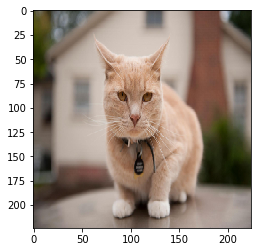

In [104]:
if (using_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png"
    img_in,img_visu = format_image_classif('cat_small.png')
else:
    img_in,img_visu = format_image_classif('images/cat_small.png')

plt.imshow(img_visu)

In [105]:
img_in.shape

(1, 224, 224, 3)

Now, we need to retrieve the last (prediction) layer of the VGG network. Do this via the variable layer_dict created above, and calling the correct layer (similarly to when we called the 'block5_conv2' layer above)

In [0]:
#BEGIN STUDENT CODE
#get last layer (prediction layer)
last_layer = layer_dict['predictions']
#create a function to get last layer of the VGG16 network (using the backend function)
get_prediction_layer = layer_dict['predictions']
#END STUDENT CODE

We are going to try to force the image to recognise a 'reflex_camera'. This is number 759 of the imagenet classes. You can use any one you like in fact (apart from ones linked to cats, obviously). To see the list of classes go to :

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

Now, find the initial class of the cat image. Also display the top 5 classification results. For this, you can use the following functions :

- model.predict(img) : classification prediction of the img variable
- vgg16.decode_predictions(y, top=5)[0] : converts the numerical probabilities in the y variable to human readable classes. Here,

In [106]:
target_class = 759
# BEGIN STUDENT CODE
# carry out the network predictions on the example image
y_predicted = model.predict(img_in)
#define the true class as the initial most likely class
# true_class = ...
# print the top 5 predicted classes, with the prediction probability
y_predicted_decoded = vgg16.decode_predictions(y_predicted, top=5)[0]
print(y_predicted_decoded)
# END STUDENT CODE

40960/35363 [==================================] - 0s 0us/step
[('n02124075', 'Egyptian_cat', 0.6696185), ('n02123045', 'tabby', 0.12234392), ('n02123159', 'tiger_cat', 0.091297895), ('n02127052', 'lynx', 0.032521863), ('n04141975', 'scale', 0.0050705383)]


Now, redefine the loss to be the 'target_class' element of the last layer of the network. This is the element we shall try to maximise, in order to fool the network. Redefine also the (normalised) gradient as above, and create a function to extract the loss and the gradients, given an input image as above.

In [0]:
#BEGIN STUDENT CODE
# define loss and gradients

# normalize the gradient

# create function to retrieve loss and gradients of loss with respect to image

#END STUDENT CODE


We are now ready to perturb the image such that we misclassify it. Youhoo !

In [0]:
#reload image, to make sure we are not starting from previous point
img_in,_ = format_image_classif('images/cat_small.png')

#parameters
step = 0.5  # Gradient ascent step size
n_iterations = 100  # Number of gradient ascent steps
for ii in range(0,n_iterations):
    loss_value,grads_value = get_loss_and_grads_class([img_in])
    img_in = img_in + grads_value * step
    if (ii%5==0):
        img_show = unformat_image(np.copy(img_in))
        plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_show)
        #predict current model to see evolution of top classification
        y_predicted = model.predict(img_in)
        print(vgg16.decode_predictions(y_predicted, top=1)[0])
print('End of optimisation')
# finally, display misclassified image
img_show = unformat_image(np.copy(img_in))
plt.imshow(img_show)
#show the final top 5 classes
y_predicted = model.predict(img_in)
print(vgg16.decode_predictions(y_predicted, top=5)[0])

As you should probably see, the image is changed such that it is no longer is correctly classified. It should be classified as a 'reflex camera', or whatever you chose, with high probability. This is a problem, since a human is still able to see a cat ! Furthermore, the top 5 classifications have nothing to do with cats !! Even bigger problem !!!

# Evaluation

To evaluate the work, you should rate the code for :
- 1) Deep dream, ```retrieve_weights``` : 2 points
- 2) Deep dream, calculation of gradients (```loss``` and ```grads```) : 2 points
- 3) Adversarial examples, ```last_layer``` and ```get_prediction_layer``` : 2 points
- 4) Adversarial examples, ```y_predicted```, ```true_class``` and ```y_predicted_decoded```
- 5) Adversarial examples, get loss, gradient, normalise gradient, create function to retrieve the loss and gradients : 2 points

Each correct answer (correct formula/code and code runs) gives 2 points. Total over 10 points.